
# Twitter Sentiment 


In [80]:
from pathlib import Path
import re, json, random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
print("Completed.")

Completed.


In [81]:
DATAFILE = Path(r"E:\twitterproj\project_dataset.xlsx")
if not DATAFILE.exists():
    raise FileNotFoundError(DATAFILE)

df = pd.read_excel(DATAFILE, header=None, names=["label", "date", "user", "text"], usecols=[0,1,2,3])

TEXT_COL, LABEL_COL = "text", "label"


In [82]:
def guess_columns(frame: pd.DataFrame):
    text_candidates = [c for c in frame.columns if frame[c].dtype == 'O']
    text_col = None
    if text_candidates:
        lens = {c: frame[c].astype(str).str.len().mean() for c in text_candidates}
        text_col = max(lens, key=lens.get)
    label_candidates = []
    for c in frame.columns:
        if pd.api.types.is_numeric_dtype(frame[c]):
            uniq = pd.Series(frame[c].dropna().unique())
            if len(uniq) <= 10:
                label_candidates.append((c, set(uniq.tolist())))
    label_col = None
    for c, s in label_candidates:
        if s.issubset({0,2,4}) or s.issubset({0,1,2}):
            label_col = c; break
    if text_col is None and 'text' in frame.columns: text_col = 'text'
    if label_col is None and 'label' in frame.columns: label_col = 'label'
    if text_col is None or label_col is None:
        raise ValueError("Could not detect text/label columns. Set TEXT_COL/LABEL_COL manually.")
    return text_col, label_col

TEXT_COL, LABEL_COL = guess_columns(df)

df.columns = [c.strip() if isinstance(c, str) else c for c in df.columns]
df[TEXT_COL] = df[TEXT_COL].astype(str).str.replace(r"\s+"," ", regex=True).str.strip()

print("Text column:", TEXT_COL, "| Label column:", LABEL_COL)

Text column: text | Label column: label


In [83]:
unique_labels = sorted(df[LABEL_COL].dropna().unique())
if set(unique_labels) == {0,2,4}:
    label_map = {0:0, 2:1, 4:2}
    df[LABEL_COL] = df[LABEL_COL].map(label_map)
elif set(unique_labels).issubset({0,1,2}):
    label_map = {0:0, 1:1, 2:2}
else:
    enc = LabelEncoder()
    df[LABEL_COL] = enc.fit_transform(df[LABEL_COL])
    label_map = {int(k): int(v) for k, v in zip(enc.classes_, enc.transform(enc.classes_))}

NUM_CLASSES = int(df[LABEL_COL].nunique())
print("Label mapping (original -> normalized):", label_map)

Label mapping (original -> normalized): {0: 0, 2: 1, 4: 2}


In [84]:
URL_RE  = re.compile(r"https?://\S+|www\.\S+")
MENT_RE = re.compile(r"@\w+")
HASH_RE = re.compile(r"#(\w+)")
NEG_PATTERNS = [(r"\bcan't\b", "can not"), (r"\bdon't\b", "do not"), (r"n't\b", " not")]

def clean_tweet(t: str) -> str:
    t = t.lower()
    t = URL_RE.sub(" ", t)
    t = MENT_RE.sub(" <user> ", t)
    for pat, repl in NEG_PATTERNS: t = re.sub(pat, repl, t)
    t = HASH_RE.sub(r" hashtag_\1 ", t)
    return re.sub(r"\s+"," ", t).strip()

df['clean'] = df[TEXT_COL].apply(clean_tweet)
df[['clean', LABEL_COL]].head()

,clean,label
0,<user> i loooooooovvvvvveee my kindle2. not th...,2
1,reading my kindle2... love it... lee childs is...,2
2,"ok, first assesment of the hashtag_kindle2 ......",2
3,<user> you'll love your kindle2. i've had mine...,2
4,<user> fair enough. but i have the kindle2 and...,2


In [85]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df['clean'], df[LABEL_COL], test_size=0.30, random_state=SEED, stratify=df[LABEL_COL]
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

print(f"Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

Train=345, Val=74, Test=74


In [86]:
MAX_WORDS = 20000
MAX_LEN   = 60

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train.tolist())

Xtr = pad_sequences(tokenizer.texts_to_sequences(X_train.tolist()), maxlen=MAX_LEN, padding='post', truncating='post', value=0)
Xva = pad_sequences(tokenizer.texts_to_sequences(X_val.tolist()),   maxlen=MAX_LEN, padding='post', truncating='post', value=0)
Xte = pad_sequences(tokenizer.texts_to_sequences(X_test.tolist()),  maxlen=MAX_LEN, padding='post', truncating='post', value=0)

ytr = y_train.to_numpy(dtype="int32")
yva = y_val.to_numpy(dtype="int32")
yte = y_test.to_numpy(dtype="int32")

print("Tokenization complete. Vocab size (capped):", min(MAX_WORDS, len(tokenizer.word_index)))


Tokenization complete. Vocab size (capped): 1584


In [87]:
counts = y_train.value_counts().to_dict()
max_count = max(counts.values())
class_weight = {cls: round(max_count/cnt, 3) for cls, cnt in counts.items()}
print("Class weights:", class_weight)

Class weights: {2: 1.0, 0: 1.05, 1: 1.309}


In [88]:
EMB_DIM = 128
HID_UNITS = 64
DROPOUT = 0.3

vocab_size = min(MAX_WORDS, len(tokenizer.word_index)) + 1

model = Sequential([
    Input(shape=(MAX_LEN,), dtype='int32', name='tokens'),
    Embedding(input_dim=vocab_size, output_dim=EMB_DIM, mask_zero=True),
    Bidirectional(LSTM(HID_UNITS, return_sequences=False)),
    Dropout(DROPOUT),
    Dense(64, activation='relu'),
    Dropout(DROPOUT),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 60, 128)             │         202,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,147 (1.18 MB)

 Trainable params: 310,147 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
ckpt_path = 'best_bilstm_sentiment.keras'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True)
]

history = model.fit(
    Xtr, ytr,
    epochs=12,
    batch_size=64,
    validation_data=(Xva, yva),
    callbacks=callbacks,
    class_weight=class_weight
)

Epoch 1/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 491ms/step - accuracy: 0.3025 - loss: 1.2092 - val_accuracy: 0.6757 - val_loss: 1.0864
Epoch 2/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.6972 - loss: 1.1723 - val_accuracy: 0.7297 - val_loss: 1.0487
Epoch 3/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.8161 - loss: 1.0630 - val_accuracy: 0.7432 - val_loss: 0.8996
Epoch 4/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.8946 - loss: 0.7226 - val_accuracy: 0.7568 - val_loss: 0.7388
Epoch 5/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9521 - loss: 0.2989 - val_accuracy: 0.7162 - val_loss: 0.9800
Epoch 6/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9731 - loss: 0.1376 - val_accuracy: 0.7027 - val_loss: 1.2717
Epoch 7/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9910 - loss: 0.0358 - val_accuracy: 0.6757 - val_loss: 1.6886


In [90]:
probs = model.predict(Xte)
ypred = probs.argmax(axis=1)

test_acc = (ypred == y_test.values).mean()
macro_f1 = f1_score(y_test.values, ypred, average='macro')
print(f"Test Accuracy: {test_acc:.4f}  |  Macro F1: {macro_f1:.4f}\n")

print("Per-class report:\n")
print(classification_report(y_test.values, ypred, digits=4))

cm = confusion_matrix(y_test.values, ypred)
print("Confusion matrix:\n", cm)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 568ms/step
Test Accuracy: 0.6216  |  Macro F1: 0.6205

Per-class report:

              precision    recall  f1-score   support

           0     0.8571    0.4615    0.6000        26
           1     0.6087    0.6667    0.6364        21
           2     0.5405    0.7407    0.6250        27

    accuracy                         0.6216        74
   macro avg     0.6688    0.6230    0.6205        74
weighted avg     0.6711    0.6216    0.6194        74

Confusion matrix:
 [[12  3 11]
 [ 1 14  6]
 [ 1  6 20]]


In [91]:
inv_map = {v:k for k,v in label_map.items()}  
ytrue_orig = np.vectorize(inv_map.get)(y_test.values)
yhat_orig  = np.vectorize(inv_map.get)(ypred)

names_orig = {0: "Sad", 2: "Neutral", 4: "Very Happy"}

df_pred = pd.DataFrame({
    "Text": X_test.tolist(),
    "True_Label": ytrue_orig,
    "Predicted_Label": yhat_orig,
    "True_Sentiment":      [names_orig[int(i)] for i in ytrue_orig],
    "Predicted_Sentiment": [names_orig[int(i)] for i in yhat_orig],
})

print("\nPreview of predictions table (first 20 rows):")
display(df_pred.head(20))

df_pred.to_csv("predictions_english.csv", index=False)


Preview of predictions table (first 20 rows):


,Text,True_Label,Predicted_Label,True_Sentiment,Predicted_Sentiment
0,iphone may get radio tagging and nike : recent...,2,2,Neutral,Neutral
1,good video from google on using search options.,4,2,Very Happy,Neutral
2,i can not watch tv without a tivo. and after a...,0,0,Sad,Sad
3,rt <user> : ca merced's water bottled by safew...,2,2,Neutral,Neutral
4,i hate comcast right now. everything is down c...,0,0,Sad,Sad
5,nooooooo my dvr just died and i was only half ...,0,0,Sad,Sad
6,i'm really loving the new search site wolfram/...,4,4,Very Happy,Very Happy
7,@ safeway. place is a nightmare right now. bum...,0,4,Sad,Very Happy
8,devsnippets : jquery tools - javascript ui com...,2,2,Neutral,Neutral
9,fuck no internet damn time warner!,0,0,Sad,Sad


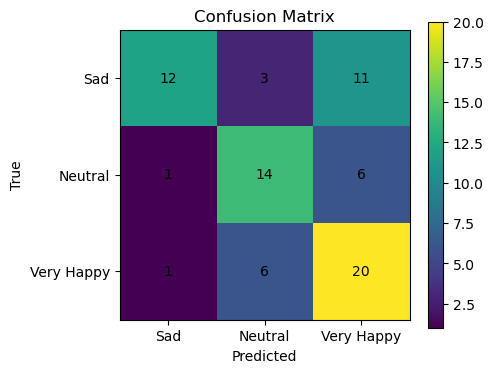

In [92]:
labels_orig = [0, 2, 4]
tick_names  = ["Sad", "Neutral", "Very Happy"]

cm = confusion_matrix(ytrue_orig, yhat_orig, labels=labels_orig)

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix")
ax.set_xticks(range(len(labels_orig))); ax.set_xticklabels(tick_names)
ax.set_yticks(range(len(labels_orig))); ax.set_yticklabels(tick_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.colorbar(im); plt.tight_layout()

png_path = "confusion_matrix_english.png"
plt.savefig(png_path, dpi=160)
plt.show()

In [93]:
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer.to_json())

with open('label_map.json', 'w', encoding='utf-8') as f:
    json.dump({str(k): int(v) for k, v in label_map.items()}, f, ensure_ascii=False, indent=2)

meta = {'text_col': str(TEXT_COL), 'label_col': str(LABEL_COL), 'num_classes': int(NUM_CLASSES),
        'max_words': int(MAX_WORDS), 'max_len': int(MAX_LEN)}
with open('training_meta.json', 'w', encoding='utf-8') as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

model.save('best_bilstm_sentiment.keras')

In [98]:
#-----Baseline (TF-IDF with Logistic Regression)-----
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
baseline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ("lr", LogisticRegression(max_iter=1000))
])
baseline.fit(X_train, y_train)

y_hat = baseline.predict(X_test)
print("Baseline Accuracy:", round(accuracy_score(y_test, y_hat), 4),
      "| Macro F1:", round(f1_score(y_test, y_hat, average='macro'), 4))
print("Confusion:\n", confusion_matrix(y_test, y_hat))
print(classification_report(y_test, y_hat, digits=4))

Baseline Accuracy: 0.6081 | Macro F1: 0.5893
Confusion:
 [[17  2  7]
 [ 6  8  7]
 [ 4  3 20]]
              precision    recall  f1-score   support

           0     0.6296    0.6538    0.6415        26
           1     0.6154    0.3810    0.4706        21
           2     0.5882    0.7407    0.6557        27

    accuracy                         0.6081        74
   macro avg     0.6111    0.5918    0.5893        74
weighted avg     0.6105    0.6081    0.5982        74



In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
pipe = Pipeline([
  ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
  ("lr", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

grid = {
  "tfidf__ngram_range": [(1,1),(1,2),(1,3)],
  "tfidf__min_df": [1,2,3],
  "lr__C": [0.5, 1, 2, 4]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, grid, scoring="f1_macro", cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)
print("Marco F1:", gs.best_score_)